# Paytm Challenge - Weblog Challenge

## Part-1

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
# Auto reload custom modules

In [2]:
from pathlib import Path
from datetime import timedelta

import pandas as pd
import numpy as np

from WebLog import Reader

import matplotlib.pyplot as plt
plt.style.use("dark_background")

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [3]:
PATH = Path("../data/")
OUTPUT_PATH = Path("../output/")
OUTPUT_PATH.mkdir(exist_ok=True)

nrows=None
# nrows=100000

In [4]:
log_regex_pattern = r'(\S+) (\S+) (\S+) (\S+) (\S+) (\S+) (\S+) (\S+) (\S+) (\S+) (\S+) "([^"]+)" "([^"]*)" (\S+) (\S+)'

log_columns = ("timestamp elb client:port backend:port request_processing_time \
                backend_processing_time response_processing_time elb_status_code \
                backend_status_code received_bytes sent_bytes request user_agent ssl_cipher ssl_protocol".split())

data = Reader.read(PATH/"2015_07_22_mktplace_shop_web_log_sample.log",
                   log_regex_pattern, log_columns, nrows=nrows, verbose=True)

1158500it [00:07, 156162.70it/s]


Could not read 22 rows: Bad format
Data is of shape: (1158478, 15)


In [5]:
data["timestamp"] = pd.to_datetime(data["timestamp"], format="%Y-%m-%dT%H:%M:%S.%fZ")
data["client_ip"] = data["client:port"].str.split(":", expand=True)[0]
data["url"] = data["request"].str.split(" ", expand=True)[1]
data = data.sort_values(['client_ip', 'timestamp']).reset_index(drop=True)

### 1. Sessionize the web log by IP. Sessionize = aggregrate all page hits by visitor/IP during a session.

In [6]:
data["prev_timestamp"] = data[['client_ip', 'timestamp']].groupby('client_ip').transform(lambda x:x.shift(1))
inactive_window = timedelta(seconds=10*60)
data['next_session'] = ((data['timestamp'] - data['prev_timestamp']) >= inactive_window).astype(int)
data['session'] = data.groupby("client_ip")['next_session'].cumsum()
data['session_id'] = data["client_ip"].str.cat(data["session"].astype(str), sep='_')
cols_order = ['timestamp', 'elb', 'client:port', 'client_ip', 'session', 'session_id',
              'backend:port', 'request_processing_time', 'backend_processing_time',
              'response_processing_time', 'elb_status_code', 'backend_status_code',
              'received_bytes', 'sent_bytes', 'request', 'url', 'user_agent', 'ssl_cipher', 'ssl_protocol']
# data.to_feather(OUTPUT_PATH/"Sessionized_Weblog.feather")
data[cols_order].head(5)

,timestamp,elb,client:port,client_ip,session,session_id,backend:port,request_processing_time,backend_processing_time,response_processing_time,elb_status_code,backend_status_code,received_bytes,sent_bytes,request,url,user_agent,ssl_cipher,ssl_protocol
0,2015-07-22 10:45:55.881199,marketpalce-shop,1.186.101.79:50614,1.186.101.79,0,1.186.101.79_0,10.0.6.99:80,0.000026,0.077996,0.000019,200,200,0,215,GET https://paytm.com:443/shop/wallet/balance?...,https://paytm.com:443/shop/wallet/balance?chan...,Mozilla/5.0 (Windows NT 6.3; WOW64; rv:39.0) G...,ECDHE-RSA-AES128-GCM-SHA256,TLSv1.2
1,2015-07-22 10:45:55.885488,marketpalce-shop,1.186.101.79:50613,1.186.101.79,0,1.186.101.79_0,10.0.6.199:80,0.000024,0.114374,0.00002,200,200,0,1375,GET https://paytm.com:443/shop/wallet/txnhisto...,https://paytm.com:443/shop/wallet/txnhistory?p...,Mozilla/5.0 (Windows NT 6.3; WOW64; rv:39.0) G...,ECDHE-RSA-AES128-GCM-SHA256,TLSv1.2
2,2015-07-22 10:46:27.839734,marketpalce-shop,1.186.101.79:50613,1.186.101.79,0,1.186.101.79_0,10.0.4.217:80,0.000024,0.027232,0.000023,302,302,0,17,GET https://paytm.com:443/shop/v1/frequentorde...,https://paytm.com:443/shop/v1/frequentorders?c...,Mozilla/5.0 (Windows NT 6.3; WOW64; rv:39.0) G...,ECDHE-RSA-AES128-GCM-SHA256,TLSv1.2
3,2015-07-22 10:46:56.591943,marketpalce-shop,1.186.101.79:50613,1.186.101.79,0,1.186.101.79_0,10.0.6.199:80,0.000024,0.028501,0.00002,200,200,105,700,POST https://paytm.com:443/papi/v1/expresscart...,https://paytm.com:443/papi/v1/expresscart/verify,Mozilla/5.0 (Windows NT 6.3; WOW64; rv:39.0) G...,ECDHE-RSA-AES128-GCM-SHA256,TLSv1.2
4,2015-07-22 10:47:01.782695,marketpalce-shop,1.186.101.79:50613,1.186.101.79,0,1.186.101.79_0,10.0.4.225:80,0.000025,0.085386,0.000025,200,200,1102,528,POST https://paytm.com:443/api/v1/expresscart/...,https://paytm.com:443/api/v1/expresscart/check...,Mozilla/5.0 (Windows NT 6.3; WOW64; rv:39.0) G...,ECDHE-RSA-AES128-GCM-SHA256,TLSv1.2


In [7]:
# Drop user sessions with only first session and one record in the data
user_counts = data["session_id"].value_counts().reset_index().rename(columns={'index': 'session_id', 'session_id': 'count'})
single_record_sessions = user_counts.loc[user_counts["count"] == 1, "session_id"].values
data = data[~((data["session_id"].isin(single_record_sessions)) & (data["session"] == 0))]

### 2. Determine the average session time

In [8]:
session_length_data = (data[['session_id', 'timestamp']].groupby('session_id')
                                                        .agg({'timestamp': [('session_length', lambda x: np.ptp(x).seconds)]}))
session_length_data.columns = session_length_data.columns.droplevel()
session_length_data.reset_index(drop=False, inplace=True)
session_length_data["client_ip"], session_length_data["session"] = session_length_data["session_id"].str.split("_").str
session_length_data["session"] = session_length_data["session"].astype(int)
print(f"Average session time across all users: {session_length_data['session_length'].mean()} seconds")

Average session time across all users: 90.59159746997969 seconds


### 3. Determine unique URL visits per session. To clarify, count a hit to a unique URL only once per session.

In [9]:
url_count_data = (data[['session_id', 'url']].groupby('session_id')
                                             .agg({'url': [('unique_url_count', lambda x: x.nunique())]}))
url_count_data.columns = url_count_data.columns.droplevel()
url_count_data.reset_index(drop=False, inplace=True)
# url_count_data.to_feather(OUTPUT_PATH/"URL_count_per_session.feather")
url_count_data.head(10)

,session_id,unique_url_count
0,1.186.101.79_0,9
1,1.186.101.79_1,8
2,1.186.103.240_0,5
3,1.186.103.78_0,4
4,1.186.108.213_0,2
5,1.186.108.230_0,5
6,1.186.108.242_0,3
7,1.186.108.28_0,80
8,1.186.108.29_0,3
9,1.186.108.79_0,3


### 4. Find the most engaged users, ie the IPs with the longest session times

In [10]:
ip_data = (session_length_data.groupby('client_ip')['session_length'].agg([('average_session_length', np.mean),
                                                                           ('number_of_sessions', 'count')])
                                                                     .reset_index()
                                                                     .sort_values('average_session_length', ascending=False))
n = 100 # To get top 100 most engaged users
top_n_users = ip_data.iloc[:n]
# top_n_users.to_parquet(OUTPUT_PATH/"Top_n_users.par")
top_n_users.head(10)

,client_ip,average_session_length,number_of_sessions
51488,182.66.36.72,1162.0,1
65912,49.202.59.215,1157.0,1
35821,122.160.158.81,1145.0,1
70541,59.91.249.99,1141.0,1
72316,61.8.146.66,1139.0,1
50137,180.215.72.113,1139.0,1
71613,60.254.126.213,1134.0,1
1150,1.23.30.226,1134.0,1
26510,117.203.81.246,1130.0,1
17647,112.79.36.86,1129.0,1


## Part-2

### 1. Predict the expected load (requests/second) in the next minute

In [11]:
load_data = data.set_index("timestamp").resample("1Min").agg({'elb': [('Load', lambda x: np.count_nonzero(x)/60)],
                                                        'sent_bytes': [('sent_bytes', lambda x: x.astype(float).sum())],
                                                        'received_bytes': [('received_bytes', lambda x: x.astype(float).sum())],
                                                        'response_processing_time': [('response_processing_time', lambda x: pd.Series(x).replace({'-1': '0'}).astype(float).sum())],
                                                        'session_id': [('sessions_active', lambda x: x.nunique())]}).reset_index(col_fill="Time")
load_data.columns = load_data.columns.droplevel()

lag_cols = ["sent_bytes", "received_bytes", "response_processing_time", "sessions_active"]
tmp = load_data[lag_cols+["Load"]].shift(1)
tmp.columns = ["Prev_" + col for col in lag_cols+["Load"]]
load_data = pd.concat((load_data.drop(lag_cols, axis=1), tmp), axis=1).fillna(0)
load_data["Minute"] = load_data["Time"].dt.minute
cols_for_model = np.setdiff1d(load_data.columns, ["Time", "Load"])
load_data.head()

,Time,Load,Prev_sent_bytes,Prev_received_bytes,Prev_response_processing_time,Prev_sessions_active,Prev_Load,Minute
0,2015-07-22 02:40:00,75.366667,0.0,0.0,0.000000,0.0,0.000000,40
1,2015-07-22 02:41:00,111.200000,21211390.0,88222.0,0.096623,598.0,75.366667,41
2,2015-07-22 02:42:00,90.816667,39794965.0,132595.0,0.137929,676.0,111.200000,42
3,2015-07-22 02:43:00,76.550000,24441018.0,109528.0,0.117509,650.0,90.816667,43
4,2015-07-22 02:44:00,74.833333,25659984.0,95128.0,0.097638,684.0,76.550000,44


### Random forest model on lag data for predicting expected load

In [12]:
# build:val:test = 60:20:20 Time based split
train, test, y_train, y_test = train_test_split(load_data, load_data["Load"], test_size=0.2, random_state=2018, shuffle=False)
# train, test, y_train, y_test = train_test_split(load_data, np.log1p(load_data["Load"]), test_size=0.2, random_state=2018, shuffle=False)
build, val, y_build, y_val = train_test_split(train, y_train, test_size=0.25, random_state=2018, shuffle=False)
print(f" Build data shape: {build.shape}, Validation data shape: {val.shape} and Testing data shape: {test.shape}")

 Build data shape: (666, 8), Validation data shape: (222, 8) and Testing data shape: (223, 8)


In [13]:
rf = RandomForestRegressor(n_estimators=100, n_jobs=4, random_state=2018)
rf.fit(build[cols_for_model], y_build)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=4,
           oob_score=False, random_state=2018, verbose=0, warm_start=False)

In [14]:
val_preds = rf.predict(val[cols_for_model])
test_preds = rf.predict(test[cols_for_model])
print(f"Validation RMSE: {mean_squared_error(y_val, val_preds)**0.5}")
print(f"Test RMSE: {mean_squared_error(y_test, test_preds)**0.5}")

Validation RMSE: 35.99255565033318
Test RMSE: 30.0611971239124


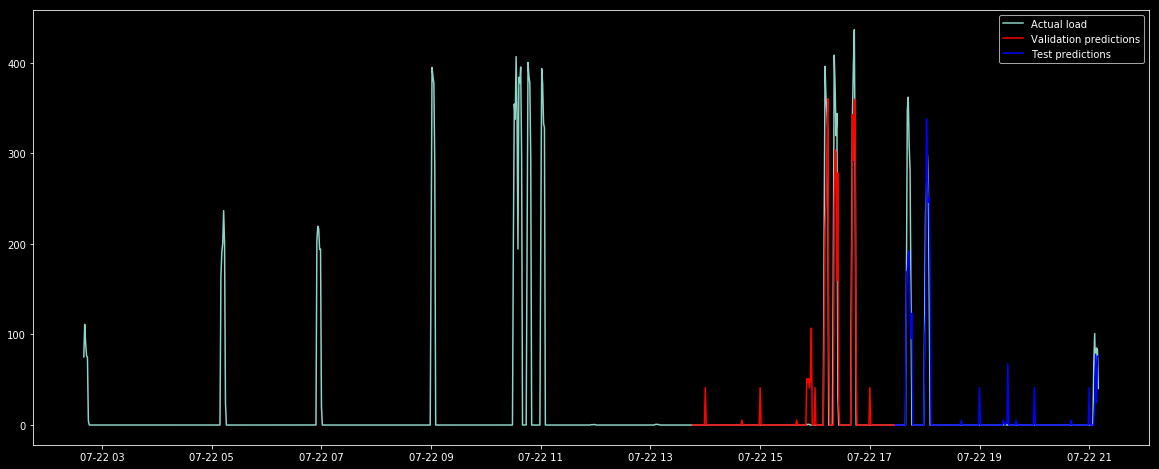

In [15]:
plt.figure(figsize=(20,8))
plt.plot(load_data[["Time", "Load"]].set_index("Time"), label="Actual load")
plt.plot(pd.concat((val["Time"].reset_index(drop=True), pd.Series(val_preds, name="Load")), axis=1).set_index("Time"), color="red", label="Validation predictions")
plt.plot(pd.concat((test["Time"].reset_index(drop=True), pd.Series(test_preds, name="Load")), axis=1).set_index("Time"), color="blue", label="Test predictions")
# plt.plot(pd.concat((val["Time"].reset_index(drop=True), pd.Series(np.expm1(reg_lgb.predict(val[cols_for_model])), name="Load")), axis=1).set_index("Time"), color="red", label="Validation predictions")
# plt.plot(pd.concat((test["Time"].reset_index(drop=True), pd.Series(np.expm1(reg_lgb.predict(test[cols_for_model])), name="Load")), axis=1).set_index("Time"), color="blue", label="Test predictions")
plt.legend()

### 2. Predict the session length for a given IP

In [16]:
data_df = data.copy(deep=True)
cols = ["sent_bytes", "received_bytes", "response_processing_time"]
data_df[cols] = data_df[cols].astype(np.float)
data_df["Device"] = data_df["user_agent"].str.contains("Mobile").replace({False: "Web", True: "Mobile"})
data_df["request_method"] = data_df["request"].str.split(" ", expand=True)[0]

In [17]:
device_data = (data_df[["session_id", "Device"]].pivot_table(index="session_id", 
                                                    columns=["Device"], 
                                                    aggfunc=np.count_nonzero)
                                                .reset_index().rename_axis(None, axis=1).fillna(0))
session_details = data_df[["session_id"]+cols].pivot_table(index="session_id", values=cols).reset_index()

#### Creating lag features based on session for each client

In [18]:
lag_cols = ["Mobile", "Web", "DELETE", "GET", "HEAD", "OPTIONS", "POST", "PUT", 
            "received_bytes", "response_processing_time", "sent_bytes",
            "session_length", "unique_url_count"]
lag_cols = ["Mobile", "Web",
            "received_bytes", "response_processing_time", "sent_bytes",
            "session_length", "unique_url_count"]
tmp_0 = (pd.merge(session_length_data, url_count_data, how='left', on='session_id')
           .merge(device_data, on="session_id", how='left')
           .merge(session_details, on="session_id", how='left'))

tmp_1 = tmp_0.groupby("client_ip")[lag_cols].transform(lambda x: x.shift(1)).rename(columns=dict(zip(lag_cols, ["Prev_"+col for col in lag_cols])))
session_data = pd.concat((tmp_0.drop(np.setdiff1d(lag_cols, ["session_length", "unique_url_count"]), axis=1), 
                          tmp_1), axis=1)
session_data.head()

,session_id,session_length,client_ip,session,unique_url_count,Prev_Mobile,Prev_Web,Prev_received_bytes,Prev_response_processing_time,Prev_sent_bytes,Prev_session_length,Prev_unique_url_count
0,1.186.101.79_0,146,1.186.101.79,0,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.186.101.79_1,229,1.186.101.79,1,8,0.0,38.0,83.105263,0.000021,2168.789474,146.0,9.0
2,1.186.103.240_0,11,1.186.103.240,0,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.186.103.78_0,9,1.186.103.78,0,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.186.108.213_0,112,1.186.108.213,0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
# Data is split based on session
# First 5 sessions in train
build = session_data[session_data["session"] < 6].fillna(0)
val = session_data[session_data["session"] == 6].fillna(0)
test = session_data[session_data["session"] > 6].fillna(0)

In [20]:
cols_for_model = ['Prev_Mobile', 'Prev_Web',
                   'Prev_received_bytes', 'Prev_response_processing_time',
                   'Prev_sent_bytes', 'Prev_session_length', 'Prev_unique_url_count']

In [21]:
rf_session_length = RandomForestRegressor(n_estimators=500, n_jobs=4, random_state=2018)
rf_session_length.fit(build[cols_for_model], np.log1p(build["session_length"]))

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=4,
           oob_score=False, random_state=2018, verbose=0, warm_start=False)

In [22]:
val_session_length_preds = rf_session_length.predict(val[cols_for_model])
test_session_length_preds = rf_session_length.predict(test[cols_for_model])
print(f"Validation RMSE: {mean_squared_error(val['session_length'], np.expm1(val_session_length_preds))**0.5}")
print(f"Test RMSE: {mean_squared_error(test['session_length'], np.expm1(test_session_length_preds))**0.5}")

Validation RMSE: 261.5820117120785
Test RMSE: 153.81379389121065


### 3. Predict the number of unique URL visits by a given IP

In [23]:
rf_url_count = RandomForestRegressor(n_estimators=500, n_jobs=4, random_state=2018)
rf_url_count.fit(build[cols_for_model], build["unique_url_count"])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=4,
           oob_score=False, random_state=2018, verbose=0, warm_start=False)

In [24]:
val_url_count_preds = rf_url_count.predict(val[cols_for_model])
test_url_count_preds = rf_url_count.predict(test[cols_for_model])
print(f"Validation RMSE: {mean_squared_error(val['unique_url_count'], val_url_count_preds)**0.5}")
print(f"Test RMSE: {mean_squared_error(test['unique_url_count'], test_url_count_preds)**0.5}")

Validation RMSE: 470.2235179151198
Test RMSE: 270.2548560698397


In [25]:
test_df = test[["client_ip", "session", "session_length", "unique_url_count"]].copy()
test_df["session_length_prediction"] = np.expm1(test_session_length_preds)
test_df["unique_url_count_prediction"] = test_url_count_preds
# test_df.to_parquet(OUTPUT_PATH/"session_predictions.parquet")